### Feature map models with time-space-feature-seperable weighting functions
Here we're going to code up models with the following form:

$$r_t = \sum_{i}\sum_{\tau}\sum_{x,y} \phi_{i}(s(t-\tau,x,y))w(\tau,x,y; \theta))\nu_{i}+\epsilon$$

Where $r_t$ is the response of some neural unit at time $t$, $(x,y)$ are spatial coordinates, and $\phi_i$ is a nonlinear feature map that is a function of a movie $s(t-\tau,x,y)$. The adjustable parameters are $\theta$, which specifies the space-time kernel $w$, and a set of independent features weights $\nu_{i}$.

In this model, we assume that the neuron views each feature map through the same spatial and temporal window $w$, but that it weights each feature map $\phi_i$ according to it's importance $\nu_i$. This is the fundamental assumption and it seems to be pretty valid, given what I know about vision at least.

Our goal will be to infer the space-time kernel and feature weights that best predict measured activity $r$. We can perform this optimization for many voxels/neurons. The feature maps will be the same for each voxel/neuron, but the space-time kernel and feature weights will change according to the characteristics of each.

In this version of the model feature and space-time selectivity are separable. Also, the space-time kernel is written as a parameterized function, while the feature weights are completely flexible--i.e., there is one independent feature weight per feature map. We can consider other variants, for example, where space and time are also separable, and where the feature weights are also a parameterized function of the features:

$$r_t = \sum_{i}\sum_{\tau}\sum_{x,y} \phi_{i}(s(t-\tau,x,y))g(x,y; \theta_{space}))f(\tau; \theta_{time}) \nu(i; \theta_{feature})+\epsilon$$ 

where $g$, $f$, and $\nu$ are functions of space, time, and feature, respectively.

An interesting variant would add an activation nonlinearity before application of the feature weights:

$$r_t = \sum_{i}\sum_{\tau}\sum_{x,y} act(\phi_{i}(s(t-\tau,x,y))g(x,y; \theta_{space}))f(\tau; \theta_{time}); exponent) \nu(i; \theta_{feature})+\epsilon$$ 

The more we separate, the more interpretable the model becomes, and the fewer parameters we have to fit. The crucial separation is space/feature, so that the number of parameters = *number of pixels* + *number of features*, instead of the product of these two terms. The more we separate, of course, the more likely we are to miss potentially important interactions between space, time, and feature.

Currently the code is being designed to accomodate two kinds of optimiziation: a brute force grid search (the G dimension below) and some kind of regression or gradient-based procedure. The idea is that there are only a few RF kernel parameters so we can probably optimize these via a stupid brute-force search. Meanwhile, there are likely to be many feature map weights, so we optimize these using regression or gradient methods. The potentially nice thing about brute-forcing the RF params is that we won't have to do an iterative optimization procedure (in principle). Instead we regress over all possible RFkernels, and take the best one. It's an empirical question what params are best brute-forced, and which are best folded into the gradient descent procedure. The goal, however, is to not resort to an iterative, EM-like scheme where we have to assume values of one set of parameters in order to optimize the other set, and so forth.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tnsr
from theano import function, scan
from time import time


from hrf_fitting.src.features import make_complex_gabor as gaborme

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX 760


### Some code for making feature maps.
For example, with Gabors.
This stage produces the feature maps =  T x D tensor. 

Question: normalize w.r.t. feature maps, or w.r.t. pixels within feature maps?

In [2]:
##parameters for designing gabor feature maps 
pixel_per_deg = 34.751    ##determined by experiment 34.751 = match/nonmatch exp.
pixels_per_stimulus = 768 ##det. by exp. 768 = match/nonmatch exp.
cycles_per_pixel = np.linspace(0.000288,0.083451,num=10)  ##cyc/pix
cycles_per_fwhm = 1.0
fwhms_per_kernel = 2.5 ##determines how big the gabor should be.

metrics = {'cycles per pixel':cycles_per_pixel,
           'pixels per cycle': 1./cycles_per_pixel,
           'cycles per stimulus': cycles_per_pixel*pixels_per_stimulus,
           'cycles per deg.': cycles_per_pixel*pixel_per_deg,
           'fwhm (pix)': np.clip(cycles_per_fwhm/cycles_per_pixel,0,pixels_per_stimulus),
           'prf_size (deg)': np.clip(cycles_per_fwhm/cycles_per_pixel,0,pixels_per_stimulus)/pixel_per_deg/2.,
           'n_pix': np.clip(fwhms_per_kernel*cycles_per_fwhm/cycles_per_pixel,0,pixels_per_stimulus)}

fm = pd.DataFrame(metrics)
fm

,cycles per deg.,cycles per pixel,cycles per stimulus,fwhm (pix),n_pix,pixels per cycle,prf_size (deg)
0,0.010008,0.000288,0.221184,768.000000,768.000000,3472.222222,11.050042
1,0.331119,0.009528,7.317760,104.950149,262.375372,104.950149,1.510031
2,0.652230,0.018769,14.414336,53.280290,133.200725,53.280290,0.766601
3,0.973341,0.028009,21.510912,35.702810,89.257025,35.702810,0.513695
4,1.294452,0.037249,28.607488,26.846118,67.115295,26.846118,0.386264
5,1.615562,0.046490,35.704064,21.510156,53.775391,21.510156,0.309490
6,1.936673,0.055730,42.800640,17.943657,44.859142,17.943657,0.258175
7,2.257784,0.064970,49.897216,15.391640,38.479101,15.391640,0.221456
8,2.578895,0.074211,56.993792,13.475152,33.687880,13.475152,0.193881
9,2.900006,0.083451,64.090368,11.983080,29.957700,11.983080,0.172413


In [3]:
idx = 9
ori = np.pi/2.
center = (0,0)
freq = fm.loc[idx,'cycles per stimulus']
fwhm = fm.loc[idx,'fwhm (pix)']
n_pix = int(fm.loc[idx,'n_pix'])

(29, 29)


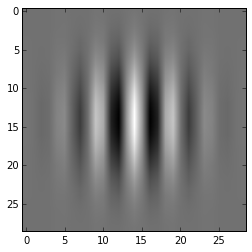

In [4]:
foo = gaborme(freq,ori,center,fwhm,n_pix)
plt.imshow(np.real(foo),cmap='gray')
print foo.shape

### Apply RF kernels in a grid
Takes the feature maps (T x D tensor) and applies multiple RF kernels. 
Produces a G x T x D tensor that we refer to as the "model space".

#### Space-time kernel function

In [5]:
def space_time_kernel(center, fwhm, n_pix, time_kernel):
    '''
    a separable space-time kernel.
    space kernel is gaussian
    time kernel is an array of length T
    returns a 3-D volume that is (n_pix,n_pix,T)
    slice it to see what it does.
    '''
    space_kernel = np.atleast_3d(make_gaussian(center,fwhm,n_pix))
    return time_kernel*space_kernel
    
    

#### construct a brute-force grid over spatial and temporal kernel and activation function params.

### Application of feature-weight tensor to model-space tensor in Theano
Something like this is what we'd need to generate predictions before we've decided what
the RF params are going to be. So this code generates predictions for all RFs, all voxels.

In [6]:
##Some fake dimensions for testing
D = 1000  ##number of feature maps
T = 1100  ##number of data samples
G = 100   ##coarse grid of r.f. centers/positions
V = 100   ##voxels (chunksize)

In [7]:
X = tnsr.tensor3('X')    ##model-space tensor: G x T x D
NU = tnsr.tensor3('NU')  ##feature weight tensor: G x D x V
Z = tnsr.batched_tensordot(X,NU,axes=[[2],[1]]) ##prediction tensor: G x T x V
bigmult = function([X,NU], Z)


In [8]:

model_space = np.random.rand(G,T,D).astype('float32')    ##RFparams x Trials x Dimensions
feature_weights = np.random.rand(G,D,V).astype('float32') ##RFparams x Dimensions x Voxels

In [9]:
start = time()
print np.einsum('gtd,gdv->gtv',model_space,feature_weights).shape  ##RFparams x Trials x Voxels
print time()-start

(100, 1100, 100)
9.11011695862


In [10]:
start = time()
print bigmult(model_space,feature_weights).shape
print time()-start

(100, 1100, 100)
0.161598920822


In [ ]:
64**2*16

^^^ For basic operation (data x weights) theano can be about x100 faster, although this seems to depend upon what else you're doing with the computer at the time. Seems important to start "fresh", with nothing else in memory.

For 400K voxels and grid size of (centers x widths x activation exponent) = (64^2 x 8 x 8) we're looking at at least 190hrs on the GPU. Probably will take more time because this doesn't include the feature-weight optimization.

If we are going to do grad. desc. on the feature weights we could potentially fold some of the RF or activation function parameters into the gradient...

### Model selection over brute-force grid (G)
Calculate error over grid, then argmax it to generate final model for each voxel.

#### some fake data

In [11]:
voxel_data = np.random.rand(T,V).astype('float32')
prediction_menu = np.random.rand(G,T,V).astype('float32')

#### the error function

In [12]:
y = tnsr.matrix('y')  ##voxel data tensor: T x V

diff = y-Z  ##difference tensor: (T x V) - (G x T x V) = (G x T x V)
sq_diff = (diff*diff).sum(axis=1) ##sum-sqaured-diffs tensor: G x V
sq_diff_func = function([y,Z],sq_diff)  ##what will this do?

In [13]:
error_menu = sq_diff_func(voxel_data,prediction_menu)
print error_menu.shape

(100, 100)


#### model selection

In [14]:
best_model_idx = error_menu.argmax(axis=0)
best_model_idx.shape

(100,)

### Gradient w.r.t. feature weights for many voxels choices of rf params (at once).


#### define a gradient
Theano only takes gradients of functions with scalar outputs. Here we have G x V outputs of the cost function and we want to take gradient with respect to the weights that are specific to each (rf_param,voxel). Instead of doing a scan over all such pairs, we exploit fact that gradient w.r.t. weights not used to compute error for each (rf_param,voxel) are just zero. So we can take gradient of the SUM of the cost matrix w.r.t. entire matrix of feature weights. 

In [15]:
SQD_sum = sq_diff.sum()  ##<<this is critical
grad_SQD_wrt_NU = tnsr.grad(SQD_sum,NU) ##<<the summing trick above makes this easy. 

In [16]:
compute_grad = function(inputs = [y,X,NU], outputs=grad_SQD_wrt_NU)

#### clock and check against explicit gradient

In [41]:
start = time()
grrrr = compute_grad(voxel_data,model_space,feature_weights)
print grrrr.shape
print time()-start

(100, 1000, 100)
0.19813990593


In [42]:
##check for one voxel/rf combo
guh = np.zeros(model_space[0,0,:].shape)
prediction_menu = bigmult(model_space,feature_weights)
start = time()

##compute one gradient
for t in range(T):
    guh += 2*(voxel_data[t,0]-prediction_menu[0,t,0])*model_space[0,t,:]

##best possible timing
print (time()-start)*G*V  

100.328922272


In [39]:
##they don't match exactly, but differences are 6-7 orders of mag smaller than errors
log10(abs(guh))-log10(abs(guh+grrrr[0,:,0]))

array([  6.61754764,   6.1432045 ,   7.3624125 ,   6.38249694,
         7.5335565 ,   6.1475923 ,   6.8695788 ,   6.22929511,
         6.14372321,   6.855668  ,   6.35062476,   7.36832682,
         6.54832894,   6.66065516,   6.55350642,   6.26397715,
         6.68474655,   6.05754205,   6.36530005,   6.76825853,
         6.17747046,   7.63193588,   7.32845471,   6.27968951,
         6.45165978,   6.21345081,   6.23943307,   6.37073244,
         6.09105955,   6.07782233,   7.26795183,   6.33278768,
         6.45475608,   6.64677811,   6.25765285,   7.93617194,
         6.51763807,   6.08901342,   6.60634824,   6.38702685,
         7.02384474,   6.38460333,   6.60832025,   6.40166964,
         6.36462104,   6.46272841,   6.14169673,   6.25457408,
         6.69186247,   7.34425431,   6.4484126 ,   6.18534566,
         6.09642416,   6.54604719,   7.43344591,   6.71044799,
         7.86687706,   6.39815145,   6.31276534,   6.31328297,
         6.73606178,   6.19305411,   6.89437807,   6.47

#### fake data

In [ ]:
Tv = 200
training_model_space
training_voxel_data
validation_model_space
validation_voxel_data

### Training loop with early stopping, mini-batch sgd
http://deeplearning.net/tutorial/gettingstarted.html

In [ ]:
#specify number of training batches
n_train_batches = ...

# early-stopping parameters
patience = 5000  # look as this many examples regardless
patience_increase = 2     # wait this much longer when a new best is
                              # found
improvement_threshold = 0.995  # a relative improvement of this much is
                               # considered significant
validation_frequency = min(n_train_batches, patience/2)
                              # go through this many
                              # minibatches before checking the network
                              # on the validation set; in this case we
                              # check every epoch

                
best_params = None
best_validation_loss = numpy.inf
test_score = 0.
start_time = time.clock()

done_looping = False
epoch = 0
while (epoch < n_epochs) and (not done_looping):
    # Report "1" for first epoch, "n_epochs" for last epoch
    epoch = epoch + 1
    for minibatch_index in xrange(n_train_batches):

        d_loss_wrt_params = compute_grad(voxel_data, model_space, feature_weights)  ##<<must supply minibatch index
        params -= learning_rate * d_loss_wrt_params # gradient descent

        # iteration number. We want it to start at 0.
        iter = (epoch - 1) * n_train_batches + minibatch_index
        # note that if we do `iter % validation_frequency` it will be
        # true for iter = 0 which we do not want. We want it true for
        # iter = validation_frequency - 1.
        if (iter + 1) % validation_frequency == 0:
            
            prediction_menu = bigmult(validation_voxel_data,best_params)
            this_validation_loss = sq_diff_func(voxel_data,prediction_menu) # compute zero-one loss on validation set

            if this_validation_loss < best_validation_loss: ##must distribute condition across all voxels

                # improve patience if loss improvement is good enough
                if this_validation_loss < best_validation_loss * improvement_threshold:

                    patience = max(patience, iter * patience_increase)
                best_params = copy.deepcopy(params)
                best_validation_loss = this_validation_loss

        if patience <= iter:
            done_looping = True
            break

# POSTCONDITION:
# best_params refers to the best out-of-sample parameters observed during the optimization
